In [1]:
import pandas as pd

# Load the file with correct separator
df = pd.read_csv(r"D:\Dhriti\VIT\City Uni\Tariff Calculations plus Population.csv", sep=';', engine='python')

# Clean up column names
df.columns = df.columns.str.strip()

# Preview the fixed table
print(df.head())


       Country US 2024 Deficit US 2024 Exports  \
0  Afghanistan           -11.1            11.4   
1      Albania            13.4           141.7   
2      Algeria       -1,447.10        1,014.50   
3      Andorra             1.5             4.9   
4       Angola       -1,186.90           682.4   

  US 2024 Imports (Customs Basis) Trump Tariffs Alleged Trump Response  \
0                            22.6                   49%            25%   
1                           128.3                   10%            10%   
2                        2,461.60                   59%            29%   
3                             3.4                   10%            10%   
4                        1,869.20                   63%            32%   

   Population  
0  41454761.0  
1   2745972.0  
2  46164219.0  
3     80856.0  
4  36749906.0  


In [2]:


# Strip % signs and convert 'Trump Tariffs Alleged' and 'Trump Response' to float,Since the code was giving error we first formatted the column to string-then removed % and converted to float
df['Trump Tariffs Alleged'] = df['Trump Tariffs Alleged'].astype(str).str.replace('%', '', regex=False).astype(float)
df['Trump Response'] = df['Trump Response'].astype(str).str.replace('%', '', regex=False).astype(float)


# Convert trade figures to numeric
columns_to_convert = ['US 2024 Deficit', 'US 2024 Exports', 'US 2024 Imports (Customs Basis)', 'Population']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')#"bad" values are handled with a Nan value instead of givng error

# Drop rows with missing values (optional, or you can fill them)
df = df.dropna()

#  new feature columns for analysis
df['Export/Import Ratio'] = df['US 2024 Exports'] / df['US 2024 Imports (Customs Basis)']
df['Deficit % of Imports'] = df['US 2024 Deficit'] / df['US 2024 Imports (Customs Basis)']
df['Tariff-Response Gap'] = df['Trump Tariffs Alleged'] - df['Trump Response']

# Step 5: Reset index
df = df.reset_index(drop=True)

# View the first few rows
print(df.head())


               Country  US 2024 Deficit  US 2024 Exports  \
0          Afghanistan            -11.1             11.4   
1              Albania             13.4            141.7   
2              Andorra              1.5              4.9   
3  Antigua and Barbuda            550.0            573.8   
4              Armenia             39.2            160.8   

   US 2024 Imports (Customs Basis)  Trump Tariffs Alleged  Trump Response  \
0                             22.6                   49.0            25.0   
1                            128.3                   10.0            10.0   
2                              3.4                   10.0            10.0   
3                             23.8                   10.0            10.0   
4                            121.6                   10.0            10.0   

   Population  Export/Import Ratio  Deficit % of Imports  Tariff-Response Gap  
0  41454761.0             0.504425             -0.491150                 24.0  
1   2745972.0   

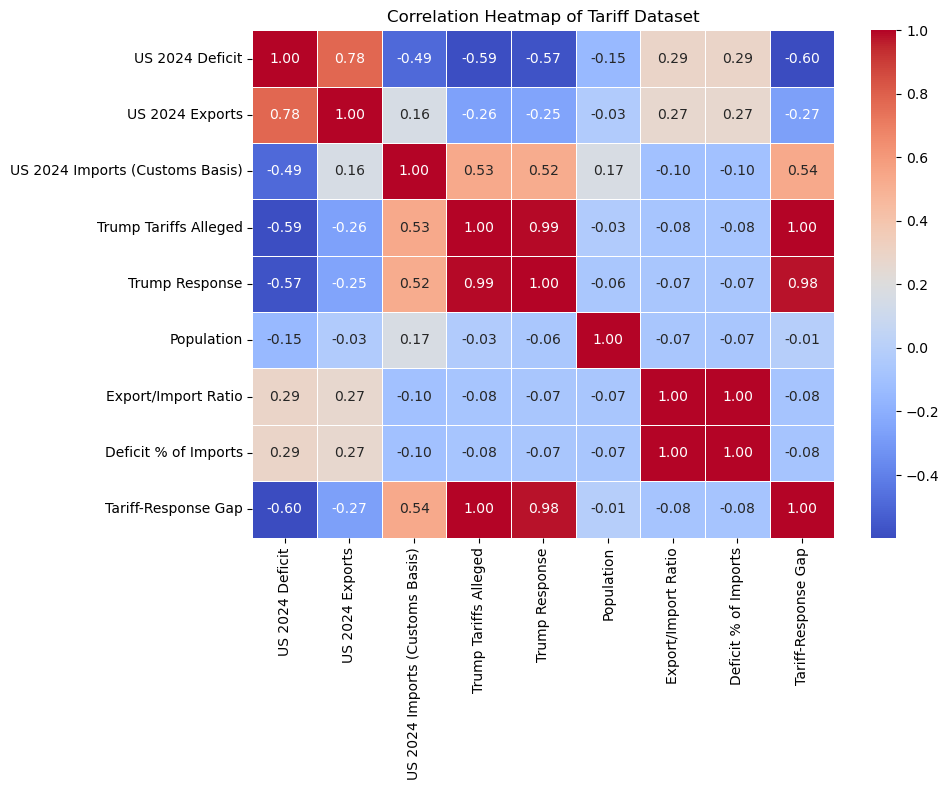

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose only numeric columns (to avoid issues)- basically only includes columns which have int or float values
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Tariff Dataset")
plt.tight_layout()
plt.show()


In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Choose features and target
features = ['Trump Tariffs Alleged', 'Trump Response', 'Export/Import Ratio',
            'Tariff-Response Gap', 'Population', 'US 2024 Exports']

X = df[features]
y = df['US 2024 Deficit']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Decision Tree model
tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# 4. Predict
y_pred = tree_model.predict(X_test)

# 5. Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))


R² Score: 0.7086527421950147
Mean Squared Error: 13465.12775727719


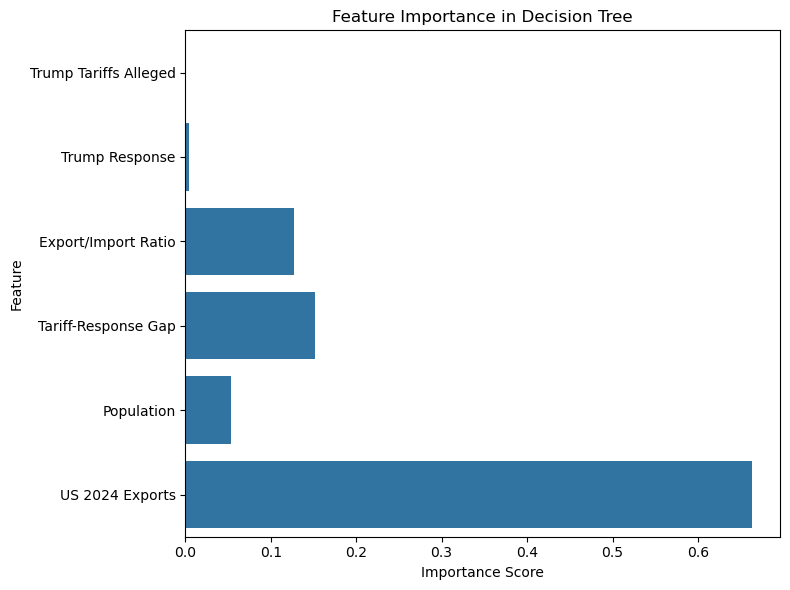

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(tree_model.feature_importances_, index=features)
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importance in Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


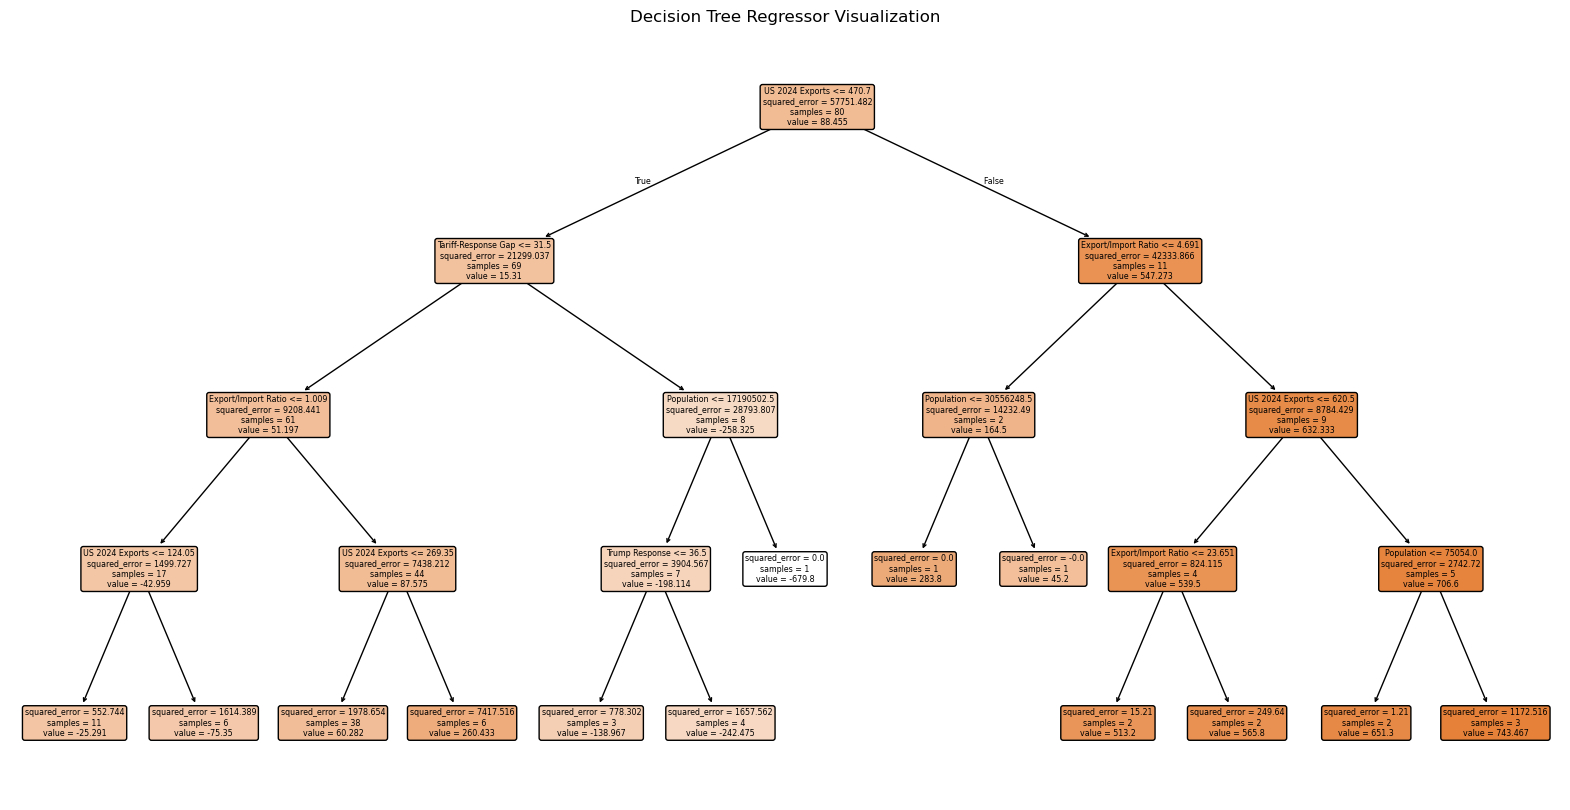

In [6]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=features, filled=True, rounded=True)
plt.title("Decision Tree Regressor Visualization")
plt.show()


In [7]:
# Calculate 25th and 75th percentiles
q1 = df['US 2024 Deficit'].quantile(0.25)
q3 = df['US 2024 Deficit'].quantile(0.75)

print(f"Q1 (25th percentile): {q1}")
print(f"Q3 (75th percentile): {q3}")


Q1 (25th percentile): -6.1
Q3 (75th percentile): 121.0


In [8]:
def impact_label(deficit):
    if deficit <= q1:
        return 'High Impact'  # worst deficits
    elif deficit >= q3:
        return 'Low Impact'   # best/no deficits
    else:
        return 'Medium Impact'

# Create new column
df['Impact Category'] = df['US 2024 Deficit'].apply(impact_label)


In [9]:

print(df['Impact Category'].value_counts())


Impact Category
Medium Impact    49
High Impact      26
Low Impact       26
Name: count, dtype: int64


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler# used to standardise scaling,such as billions against percentage; all values are measured on a standard scale
from sklearn.decomposition import PCA
# Select numerical features related to tariffs and trade
features_for_pca = ['Trump Tariffs Alleged', 'Trump Response',
                    'US 2024 Exports', 'US 2024 Imports (Customs Basis)',
                    'Tariff-Response Gap']

X = df[features_for_pca]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:
pca = PCA(n_components=2)# 2 comoponents are use to capture maximise information of the feautres while minimising variables
X_pca = pca.fit_transform(X_scaled)

# Add PCA results back to the dataframe
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]


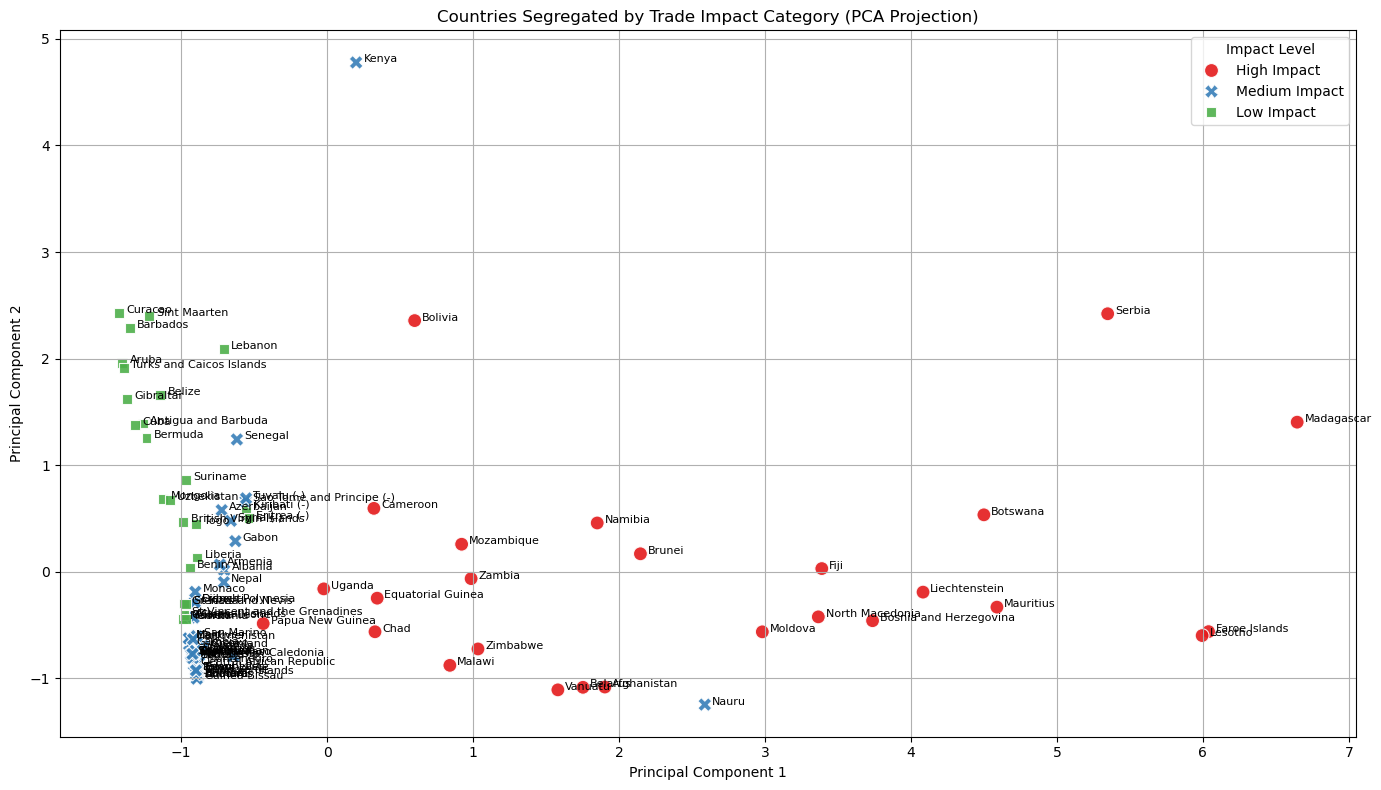

In [12]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Impact Category', style='Impact Category',
                palette='Set1', s=100, alpha=0.9)

# Annotate each point with the country name
for i in range(df.shape[0]):
    plt.text(x=df['PCA1'][i]+0.05, y=df['PCA2'][i], s=df['Country'][i], fontsize=8)

plt.title("Countries Segregated by Trade Impact Category (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Impact Level")
plt.show()


In [13]:
from sklearn.cluster import KMeans # we're plotting K means on PCA data to understand if our impact categories and clusters 

# 1. Run K-Means on the scaled features
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans Cluster'] = kmeans.fit_predict(X_scaled)


D:\anc\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


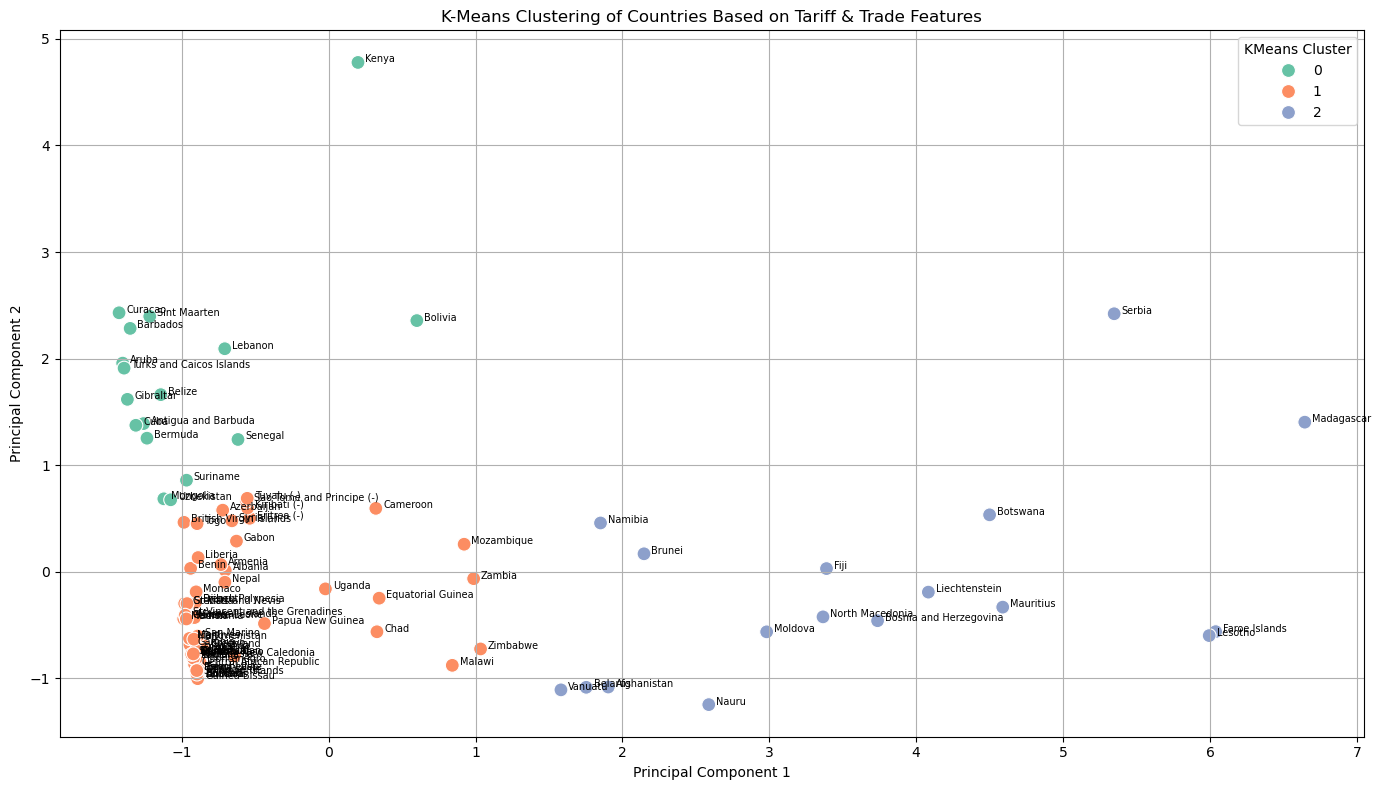

In [14]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='KMeans Cluster', palette='Set2', s=100)

# Optional: Annotate points
for i in range(df.shape[0]):
    plt.text(x=df['PCA1'][i] + 0.05, y=df['PCA2'][i], s=df['Country'][i], fontsize=7)

plt.title("K-Means Clustering of Countries Based on Tariff & Trade Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
pd.crosstab(df['KMeans Cluster'], df['Impact Category'])


Impact Category,High Impact,Low Impact,Medium Impact
KMeans Cluster,,,
0,1,14,2
1,9,12,46
2,16,0,1


In [16]:
df[df['KMeans Cluster'] != df['Impact Category']]


,Country,US 2024 Deficit,US 2024 Exports,US 2024 Imports (Customs Basis),Trump Tariffs Alleged,Trump Response,Population,Export/Import Ratio,Deficit % of Imports,Tariff-Response Gap,Impact Category,PCA1,PCA2,KMeans Cluster
0,Afghanistan,-11.1,11.4,22.6,49.0,25.0,41454761.0,0.504425,-0.491150,24.0,High Impact,1.903018,-1.081931,2
1,Albania,13.4,141.7,128.3,10.0,10.0,2745972.0,1.104443,0.104443,0.0,Medium Impact,-0.704739,0.013537,1
2,Andorra,1.5,4.9,3.4,10.0,10.0,80856.0,1.441176,0.441176,0.0,Medium Impact,-0.886127,-0.985670,1
3,Antigua and Barbuda,550.0,573.8,23.8,10.0,10.0,93316.0,24.109244,23.109244,0.0,Low Impact,-1.261103,1.390318,0
4,Armenia,39.2,160.8,121.6,10.0,10.0,2990900.0,1.322368,0.322368,0.0,Medium Impact,-0.734041,0.066975,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Uzbekistan,338.4,380.8,42.4,10.0,10.0,35652307.0,8.981132,7.981132,0.0,Low Impact,-1.076137,0.675261,0
97,Vanuatu,-6.1,7.6,13.7,45.0,22.0,320409.0,0.554745,-0.445255,23.0,High Impact,1.581135,-1.108499,2
98,Yemen,125.2,134.1,8.9,10.0,10.0,39390799.0,15.067416,14.067416,0.0,Low Impact,-0.969324,-0.442980,1
99,Zambia,-55.3,113.8,169.1,33.0,16.0,20723965.0,0.672975,-0.327025,17.0,High Impact,0.986620,-0.064736,1


K-Means independently grouped countries based on trade/tariff patterns, and one cluster (Cluster 2) strongly aligns with my 'High Impact' deficit group — revealing a block of consistently vulnerable countries. However, another cluster (Cluster 1) is more mixed, suggesting that trade structure alone doesn't fully explain impact — possibly due to non-tariff factors or macroeconomic conditions.

In [17]:
df.sort_values(by='Tariff-Response Gap', ascending=False).head(100)


,Country,US 2024 Deficit,US 2024 Exports,US 2024 Imports (Customs Basis),Trump Tariffs Alleged,Trump Response,Population,Export/Import Ratio,Deficit % of Imports,Tariff-Response Gap,Impact Category,PCA1,PCA2,KMeans Cluster
47,Lesotho,-234.5,2.8,237.3,99.0,49.0,2311472.0,0.011799,-0.988201,50.0,High Impact,5.994817,-0.599234,2
32,Faroe Islands,-248.1,1.4,249.5,99.0,50.0,54482.0,0.005611,-0.994389,49.0,High Impact,6.038824,-0.562056,2
50,Madagascar,-679.8,53.4,733.2,93.0,46.0,31195932.0,0.072831,-0.927169,47.0,High Impact,6.645826,1.403711,2
56,Mauritius,-186.5,48.0,234.5,80.0,40.0,1261041.0,0.204691,-0.795309,40.0,High Impact,4.589034,-0.332043,2
76,Serbia,-604.5,209.9,814.4,74.0,37.0,6623183.0,0.257736,-0.742264,37.0,High Impact,5.347748,2.421032,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,Central African Republic,33.6,35.1,1.4,10.0,10.0,5152421.0,25.071429,24.000000,0.0,Medium Impact,-0.913010,-0.870534,1
1,Albania,13.4,141.7,128.3,10.0,10.0,2745972.0,1.104443,0.104443,0.0,Medium Impact,-0.704739,0.013537,1
7,Barbados,724.0,772.6,48.6,10.0,10.0,282336.0,15.897119,14.897119,0.0,Low Impact,-1.352145,2.283609,0
48,Liberia,147.9,220.4,72.5,10.0,10.0,5493031.0,3.040000,2.040000,0.0,Low Impact,-0.889278,0.133194,1


In [18]:
eco_df = pd.read_csv(r"D:\Dhriti\VIT\City Uni\Global Economy Indicators.csv")
eco_df.head()


,CountryID,Country,Year,AMA exchange rate,IMF based exchange rate,Population,Currency,Per capita GNI,"Agriculture, hunting, forestry, fishing (ISIC A-B)",Changes in inventories,...,Household consumption expenditure (including Non-profit institutions serving households),Imports of goods and services,Manufacturing (ISIC D),"Mining, Manufacturing, Utilities (ISIC C-E)",Other Activities (ISIC J-P),Total Value Added,"Transport, storage and communication (ISIC I)","Wholesale, retail trade, restaurants and hotels (ISIC G-H)",Gross National Income(GNI) in USD,Gross Domestic Product (GDP)
0,4,Afghanistan,1970,0.044998,0.044998,10752971,Afghani,164,8.699174e+08,NaN,...,1.551094e+09,195277226.0,370146827.0,376690811.0,127747843.0,1.731454e+09,83917200.0,226387091.0,1.766528e+09,1.731436e+09
1,4,Afghanistan,1971,0.044998,0.044998,11015857,Afghani,168,9.108281e+08,NaN,...,1.675426e+09,276296480.0,387549502.0,394401164.0,133754097.0,1.812857e+09,87860382.0,237019196.0,1.850122e+09,1.812838e+09
2,4,Afghanistan,1972,0.044998,0.044998,11286753,Afghani,149,8.279453e+08,NaN,...,1.498812e+09,290370350.0,352284669.0,358512865.0,121582672.0,1.647918e+09,79864525.0,215477287.0,1.683948e+09,1.647900e+09
3,4,Afghanistan,1973,0.044998,0.044998,11575305,Afghani,150,8.554869e+08,NaN,...,1.508024e+09,262962880.0,364010279.0,370445793.0,125630236.0,1.702735e+09,82528885.0,222624293.0,1.739998e+09,1.702716e+09
4,4,Afghanistan,1974,0.044998,0.044998,11869879,Afghani,177,1.035913e+09,NaN,...,1.778819e+09,305679151.0,440760406.0,448552790.0,152119162.0,2.061752e+09,99918604.0,269525910.0,2.106420e+09,2.061729e+09


In [19]:
eco_df.columns = eco_df.columns.str.strip()
print(eco_df['Country'].head())
print(eco_df['Country'].dtype)
print(eco_df['Country'].isnull().sum())


0     Afghanistan 
1     Afghanistan 
2     Afghanistan 
3     Afghanistan 
4     Afghanistan 
Name: Country, dtype: object
object
0


In [20]:
eco_agg = eco_df.groupby('Country').agg({
    'Per capita GNI': 'mean',
    'Population': 'mean',
    'AMA exchange rate': 'mean',
    # Add more columns as needed
}).reset_index()

combined_df = df.merge(eco_agg, on='Country', how='left')
combined_df.head()


,Country,US 2024 Deficit,US 2024 Exports,US 2024 Imports (Customs Basis),Trump Tariffs Alleged,Trump Response,Population_x,Export/Import Ratio,Deficit % of Imports,Tariff-Response Gap,Impact Category,PCA1,PCA2,KMeans Cluster,Per capita GNI,Population_y,AMA exchange rate
0,Afghanistan,-11.1,11.4,22.6,49.0,25.0,41454761.0,0.504425,-0.491150,24.0,High Impact,1.903018,-1.081931,2,NaN,NaN,NaN
1,Albania,13.4,141.7,128.3,10.0,10.0,2745972.0,1.104443,0.104443,0.0,Medium Impact,-0.704739,0.013537,1,NaN,NaN,NaN
2,Andorra,1.5,4.9,3.4,10.0,10.0,80856.0,1.441176,0.441176,0.0,Medium Impact,-0.886127,-0.985670,1,NaN,NaN,NaN
3,Antigua and Barbuda,550.0,573.8,23.8,10.0,10.0,93316.0,24.109244,23.109244,0.0,Low Impact,-1.261103,1.390318,0,NaN,NaN,NaN
4,Armenia,39.2,160.8,121.6,10.0,10.0,2990900.0,1.322368,0.322368,0.0,Medium Impact,-0.734041,0.066975,1,NaN,NaN,NaN


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features, now including population
features = [
    'Trump Tariffs Alleged', 'Trump Response',
    'Tariff-Response Gap', 'Export/Import Ratio',
    'Deficit % of Imports', 'US 2024 Deficit', 'Population_x'
]

X = combined_df[features].dropna()  # Drop rows with missing values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans1 = KMeans(n_clusters=3, random_state=42)
combined_df.loc[X.index, 'New KMeans Cluster'] = kmeans.fit_predict(X_scaled)
combined_df.groupby('New KMeans Cluster')[
    ['US 2024 Deficit', 'Trump Tariffs Alleged', 'Trump Response',
     'Tariff-Response Gap', 'Export/Import Ratio', 'Deficit % of Imports', 'Population_x']
].mean()


D:\anc\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,US 2024 Deficit,Trump Tariffs Alleged,Trump Response,Tariff-Response Gap,Export/Import Ratio,Deficit % of Imports,Population_x
New KMeans Cluster,,,,,,,
0.0,650.200000,10.000000,10.000000,0.000000,1626.500000,1625.500000,3.847100e+04
1.0,128.431325,11.987952,10.397590,1.590361,11.483111,10.513512,1.000430e+07
2.0,-186.635294,67.058824,33.529412,33.529412,0.329282,-0.670458,6.279318e+06


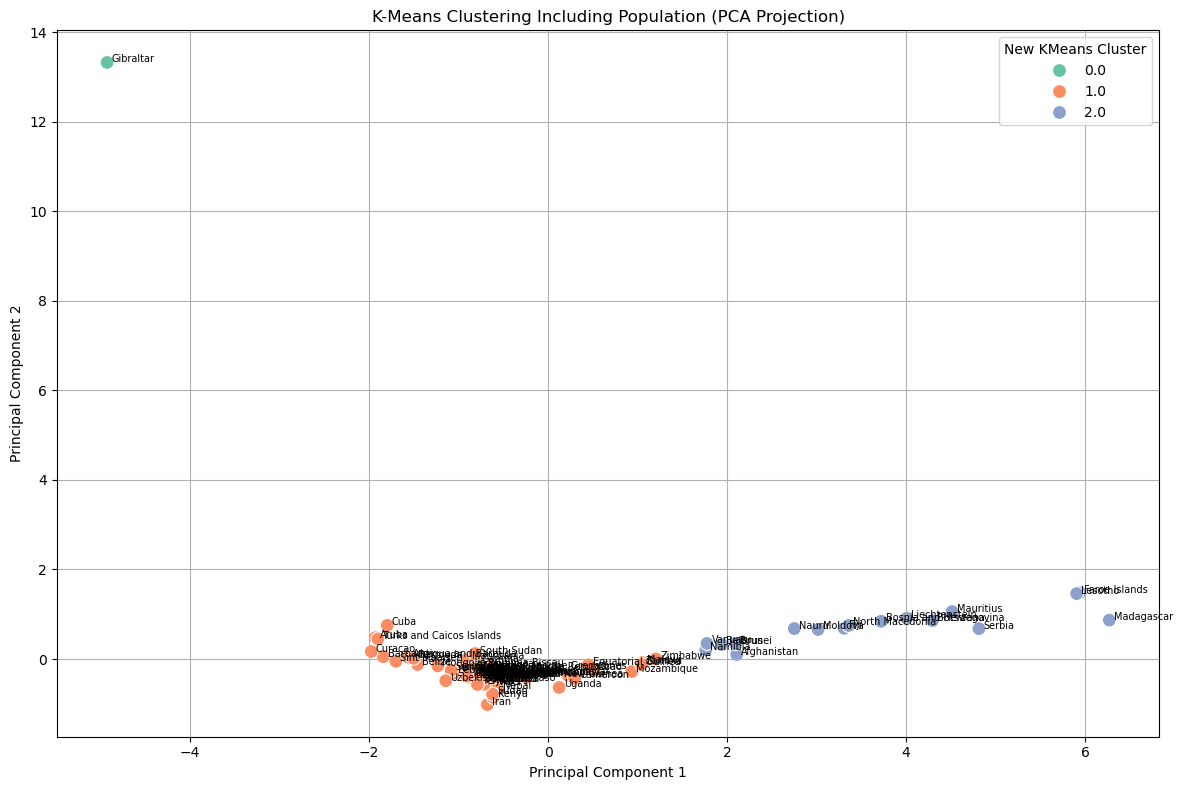

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Redefine features and prepare data again
features = [
    'Trump Tariffs Alleged', 'Trump Response',
    'Tariff-Response Gap', 'Export/Import Ratio',
    'Deficit % of Imports', 'US 2024 Deficit', 'Population_x'
]

X = combined_df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA for plotting
pca_pop = PCA(n_components=2)
X_pca_pop = pca_pop.fit_transform(X_scaled)

# Save to dataframe
combined_df.loc[X.index, 'PCA1_pop'] = X_pca_pop[:, 0]
combined_df.loc[X.index, 'PCA2_pop'] = X_pca_pop[:, 1]

# Scatter plot of new KMeans with population
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_df.loc[X.index],
    x='PCA1_pop', y='PCA2_pop',
    hue='New KMeans Cluster',
    palette='Set2',
    s=100
)

# Annotate country names
for i in X.index:
    plt.text(
        combined_df.loc[i, 'PCA1_pop'] + 0.05,
        combined_df.loc[i, 'PCA2_pop'],
        combined_df.loc[i, 'Country'],
        fontsize=7
    )

plt.title("K-Means Clustering Including Population (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
print(combined_df.columns.tolist())



['Country', 'US 2024 Deficit', 'US 2024 Exports', 'US 2024 Imports (Customs Basis)', 'Trump Tariffs Alleged', 'Trump Response', 'Population_x', 'Export/Import Ratio', 'Deficit % of Imports', 'Tariff-Response Gap', 'Impact Category', 'PCA1', 'PCA2', 'KMeans Cluster', 'Per capita GNI', 'Population_y', 'AMA exchange rate', 'New KMeans Cluster', 'PCA1_pop', 'PCA2_pop']


In [24]:
# Generate a cross-tab between the new KMeans clusters and impact categories
pd.crosstab(combined_df['New KMeans Cluster'], combined_df['Impact Category'])


Impact Category,High Impact,Low Impact,Medium Impact
New KMeans Cluster,,,
0.0,0,1,0
1.0,10,25,48
2.0,16,0,1


In [25]:
# Group countries by old and new clusters
old_clusters = combined_df.groupby('KMeans Cluster')['Country'].apply(set)
new_clusters = combined_df.groupby('New KMeans Cluster')['Country'].apply(set)

# Compare overlaps
for new_label in new_clusters.index:
    print(f"Countries in New KMeans Cluster {new_label}:\n")
    for old_label in old_clusters.index:
        overlap = new_clusters[new_label].intersection(old_clusters[old_label])
        print(f" - Shared with Old Cluster {old_label}: {len(overlap)} countries")
        if len(overlap) > 0:
            print(f"   {sorted(overlap)}")


Countries in New KMeans Cluster 0.0:

 - Shared with Old Cluster 0: 1 countries
   ['Gibraltar']
 - Shared with Old Cluster 1: 0 countries
 - Shared with Old Cluster 2: 0 countries
Countries in New KMeans Cluster 1.0:

 - Shared with Old Cluster 0: 16 countries
   ['Antigua and Barbuda', 'Aruba', 'Barbados', 'Belize', 'Bermuda', 'Bolivia', 'Cuba', 'Curacao', 'Kenya', 'Lebanon', 'Mongolia', 'Senegal', 'Sint Maarten', 'Suriname', 'Turks and Caicos Islands', 'Uzbekistan']
 - Shared with Old Cluster 1: 67 countries
   ['Albania', 'Andorra', 'Armenia', 'Azerbaijan', 'Benin', 'Bhutan', 'British Virgin Islands', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Djibouti', 'Dominica', 'Equatorial Guinea', 'Eritrea (-)', 'Eswatini', 'French Polynesia', 'Gabon', 'Gambia', 'Greenland', 'Grenada', 'Guinea', 'Guinea-Bissau', 'Iran', 'Kiribati (-)', 'Kosovo', 'Liberia', 'Malawi', 'Maldives', 'Mali', 'Marshall Islands', 'Mauritania', 'Micronesia', 'M